# Trabajo Practico 1: Bayes Ingenuo

### Estudiantes:
1. Sophia Contreras
2. Yoksan Varela
3. Mauro Viquez

In [1]:
# Librerias usadas en el codigo
import torch
import numpy as np
import torchvision
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Para remover Warnings
import warnings
warnings.filterwarnings("ignore")

# Para Pruebas unitarias
import ipytest
ipytest.autoconfig()

import sys
np.set_printoptions(threshold=sys.maxsize)

### Funciones Generales

In [2]:
def load_cifar10_dataset(is_train = True):
    """Funcion para cargar CIFAR10 dataset, tomada del notebook BayesianModel_CIFAR_base.ipynb provisto en el curso.

    Args:
        is_train (bool, optional): Especifica si el modelo se esta entrenando. Defaults to True.

    Returns:
        Tensor: Retorna los tensores con sus respectivos labels
    """
    # Define a transformation to convert images to grayscale
    transforms_1 = transforms.Compose([
      transforms.ToTensor(),
      transforms.Grayscale(num_output_channels=1)  # Convert to grayscale
    ])
    cifar_trainset = datasets.CIFAR10(root='./data', train = is_train, download = True, transform = transforms_1)
  

    # Initialize an empty list to store batches
    all_data = []
    train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size = 64, shuffle=True)
    # Iterate over the train_loader to fetch all batches
    for batch in train_loader:
        images, _ = batch  # Extract images from the batch
        all_data.append(images)

    # Concatenate all batches into a single tensor along the batch dimension
    cifar_trainset_tensor = torch.round(torch.cat(all_data, dim=0) * 255)
    cifar_labels = torch.tensor(cifar_trainset.targets)
    print("cifar_trainset_tensor shape ", cifar_trainset_tensor.shape)
    print("cifar_labels ", cifar_labels.shape)
    return (cifar_trainset_tensor, cifar_labels)

### Pregunta 1, seccion A: Crear funcion calcular_probabilidad_priori

In [3]:
def calcular_probabilidad_priori(labels,categoria):
    N = len(labels)
    cuenta_categoria = np.count_nonzero(labels == categoria)
    prob_marginal = cuenta_categoria/N
    return torch.tensor(prob_marginal)

### Pregunta 1, seccion B: Pruebas unitarias para la funcion calcular_probabilidad_priori:

In [4]:
%%ipytest

# Creando un arreglo de 10 elementos conocidos con tres categorias: 1, 2 y 3
test_tensor = torch.tensor([1,1,2,2,2,2,2,3,3,3])

def test_calcular_probabilidad_priori_1() -> None:
    # Primera prueba unitaria: Calcular la probabilidad de un 1 que es igual a 2/10 = 0.2
    prob_1 = calcular_probabilidad_priori(test_tensor,1)
    assert prob_1 == 0.2

def test_calcular_probabilidad_priori_2() -> None:
    # Segunda prueba unitaria: Calcular la probabilidad de un 2 que es igual a 5/10 = 0.5
    prob_2 = calcular_probabilidad_priori(test_tensor,2)
    assert prob_2 == 0.5

def test_calcular_probabilidad_priori_3() -> None:
    # Tercera prueba unitaria: Calcular la probabilidad de un 3 que es igual a 3/10 = 0.3
    prob_3 = calcular_probabilidad_priori(test_tensor,3)
    assert prob_3 == 0.3

def test_calcular_probabilidad_priori_suma() -> None:
    # Cuarta prueba unitaria: La suma de las todas las probabilidades de las categorias tiene que dar 1
    prob_1 = calcular_probabilidad_priori(test_tensor,1)
    prob_2 = calcular_probabilidad_priori(test_tensor,2)
    prob_3 = calcular_probabilidad_priori(test_tensor,3)
    assert (prob_1 + prob_2 + prob_3) == 1

....                                                                                         [100%]
4 passed in 0.01s


## Pregunta 1: Implementacion de la clasificacion multi-clase de imagenes con Byes Ingenuo usando histogramas

Como primer paso, tenemos que cargar el set de datos:

In [5]:
# Cargando el dataset CIFAR10
trainset_tensor,trainset_labels = load_cifar10_dataset()

100%|██████████| 170498071/170498071 [00:17<00:00, 9582842.99it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
cifar_trainset_tensor shape  torch.Size([50000, 1, 32, 32])
cifar_labels  torch.Size([50000])


Ya con el dataset cargado, se analiza la distribucion de la informacion con respecto a las categorias:

In [6]:
valores_unicos, cuenta = np.unique(trainset_labels,return_counts=True)
print(f"Lista de los valores unicos de categorias: {valores_unicos}")
print(f"Cuentas para cada uno de estos valores: {cuenta}")

Lista de los valores unicos de categorias: [0 1 2 3 4 5 6 7 8 9]
Cuentas para cada uno de estos valores: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


Hay que hacer un sampling dado que los 50000 valores estan igualmente distribuidos en las 10 categorias:

In [7]:
# Primero, creamos un arreglo del tamano de los datos con valores aleatorios, de forma que estos van a ser la forma sampleo ya que serian los indices a mantener
arr_sampleo = np.random.choice(np.arange(len(trainset_labels)), 35000, replace=False)

# Ahora se hace el sampleo tanto de imagenes como las categorias
sample_labels = trainset_labels[arr_sampleo]
sample_images = trainset_tensor[arr_sampleo,:,:,:]

In [8]:
# Ahora se comprueba que el sampling se haya hecho de forma de correcta
print("Sample of images shape ", sample_images.shape)
print("Sample of labels ", sample_labels.shape)

Sample of images shape  torch.Size([35000, 1, 32, 32])
Sample of labels  torch.Size([35000])


In [9]:
# Verificamos que ya haya aleatoriedad en las categorias
valores_unicos_sample, cuenta_sample = np.unique(sample_labels,return_counts=True)
print(f"Lista de los valores unicos de categorias: {valores_unicos_sample}")
print(f"Cuentas para cada uno de estos valores: {cuenta_sample}")

Lista de los valores unicos de categorias: [0 1 2 3 4 5 6 7 8 9]
Cuentas para cada uno de estos valores: [3469 3548 3531 3472 3513 3472 3466 3507 3500 3522]


Ya con el muestreo completo, se procede a la siguiente seccion.

### Pregunta 1, seccion C: Enfoque basado en histogramas: Hypercubo de D x Z x K
Donde D es la densidad de probablidad para cada pixel (1024 en total), Z es la intensidad de cada pixel (de 0 a 255) y K es la categoria a la que pertenece (total de 10 categorias).

In [10]:
def create_probability_per_category(data):
    # Capturando la cantidad total de imagenes. La probabilidad de cada pixel la dicta este valor.
    imagenes_qty = data.shape[0]

    # Aplanando todos los tensores para convertirlos en 1D de 1024 pixeles, y convirtiendo los datos en int64 (la funcion bincount de numpy necesita ese formato)
    tensor_flat = torch.flatten(data)
    tensor_flat = torch.tensor(tensor_flat,dtype=torch.int64)

    # Creando un tensor de # de imagenes x 1024 pixeles
    reshaped_tensor = tensor_flat.reshape(imagenes_qty,1024)

    # Haciendo la transpuesta para tener un tensor de 1024 x # de imagenes
    transposed_tensor = np.transpose(reshaped_tensor)

    # Contando la intensidad de luz por pixel para los 255 niveles. Esto genera un tensor de 1024 (cantidad de pixeles) x 255 (escala de gris)
    count_tensor = np.apply_along_axis(np.bincount, axis=1, arr=transposed_tensor, minlength = 256)

    # Finalmente, se divide todo el tensor entre el numero de imagenes procesadas para obtener la densidad de probabilidad m condicionada por t; y se retorna
    count_tensor = torch.tensor(count_tensor,dtype=torch.float32)
    probabilty_tensor = count_tensor/imagenes_qty

    return torch.tensor(probabilty_tensor)

In [11]:
def create_density_hypercube(labels,data):
    # Creando un hypercubo con las dimensiones pre-establecidas
    D = 1024
    Z = 256
    K = 10
    hypercube = torch.zeros([K,D,Z])

    for category in range(K):
        # Creando un tensor con los indices de todas las imagenes para la categoria actual
        index_list = torch.tensor(labels == category)

        # Creando un nuevo tensor con solo las imagenes que corresponden a la categoria actual
        indexed_images = torch.tensor(data[index_list])
        
        # Enviar a procesar el nuevo tensor y popular el hypercubo solo si tiene imagenes, si no, continuar con la siguiente categoria
        if(indexed_images.numel() != 0):
            # Finalmente se popula el hypercubo
            hypercube[category,:,:] = create_probability_per_category(indexed_images)
    
    return hypercube

dataset_densities = create_density_hypercube(sample_labels,sample_images)

#with open("hipercubo.csv", "w+") as file:
    # Converting the array to a string and writing to the file
    #file.write(str(dataset_densities))



### Pregunta 1, seccion C, parte 4: Histogramas

In [37]:
def plot_bar(bins, histogram, axis_x_label, axis_y_label, title):
    """Funcion para hacer el plot histogramas"""
    plt.figure()
    plt.bar(bins[:-1], histogram, color ='maroon', edgecolor='k')
    plt.xlabel(axis_x_label)
    plt.ylabel(axis_y_label)
    plt.title(title)
    plt.show()

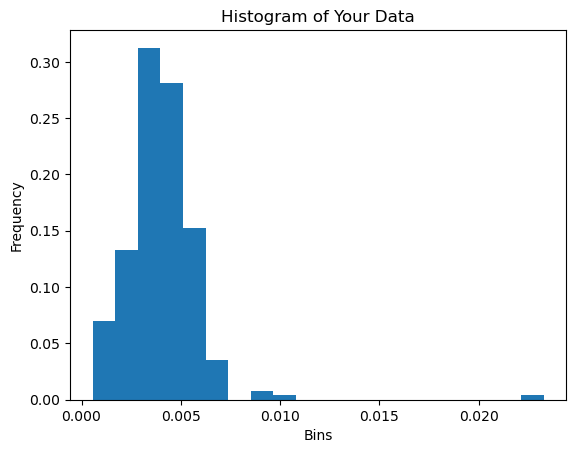

In [70]:
hist, bin_edges = np.histogram(dataset_densities[9,4,:], bins=20)

plt.bar(bin_edges[:-1], hist/hist.sum(), width=np.diff(bin_edges), align='edge')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Histogram of Your Data')
plt.show()